Anzahl gefundener Konturen: 303
Rect Werte: (256, 3976)
Rect Werte: (464, 3970)
Rect Werte: (2624, 3926)
Rect Werte: (1020, 3906)
Rect Werte: (532, 3896)
Rect Werte: (2758, 3894)
Rect Werte: (1170, 3890)
Rect Werte: (863, 3890)
Rect Werte: (1612, 3888)
Rect Werte: (2466, 3885)
Rect Werte: (1396, 3878)
Rect Werte: (2464, 3863)
Rect Werte: (1148, 3808)
Rect Werte: (2530, 3778)
Rect Werte: (1514, 3774)
Rect Werte: (2872, 3748)
Rect Werte: (2580, 3746)
Rect Werte: (1210, 3716)
Rect Werte: (920, 3704)
Rect Werte: (474, 3672)
Rect Werte: (1414, 3628)
Rect Werte: (2818, 3618)
Rect Werte: (2832, 3600)
Rect Werte: (635, 3580)
Rect Werte: (2862, 3554)
Rect Werte: (2494, 3520)
Rect Werte: (44, 3516)
Rect Werte: (754, 3514)
Rect Werte: (2754, 3512)
Rect Werte: (466, 3508)
Rect Werte: (2636, 3504)
Rect Werte: (1179, 3502)
Rect Werte: (2728, 3478)
Rect Werte: (1272, 3384)
Rect Werte: (184, 3366)
Rect Werte: (1266, 3288)
Rect Werte: (2113, 3284)
Rect Werte: (2739, 3257)
Rect Werte: (2968, 3248)
Rect 

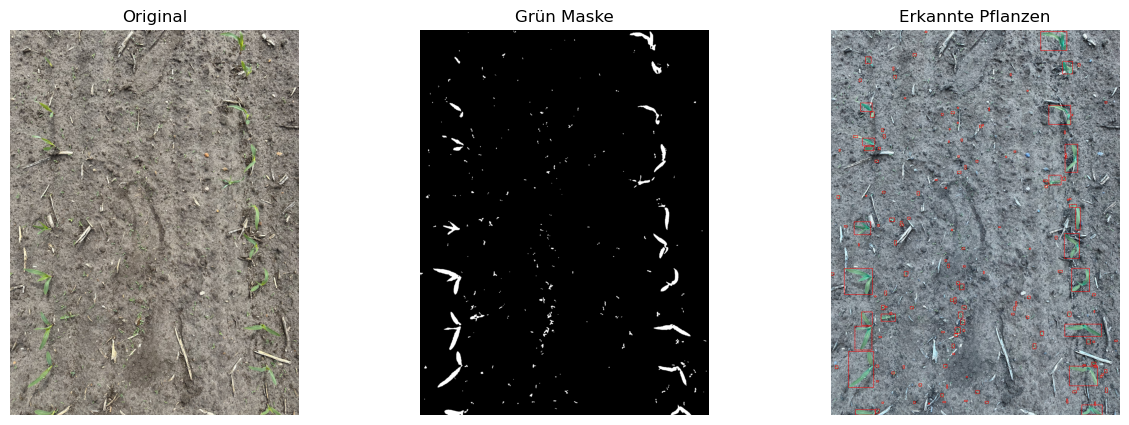

In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def detect_plant_rows_with_rectangles(image_path):
    # Bild laden
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # In HSV umwandeln
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Grünbereich definieren (anpassen je nach Bild)
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    # Morphologische Filter (Rauschen entfernen)
    kernel = np.ones((5,5), np.uint8)
    mask_clean = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

    # Konturen finden
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Anzahl gefundener Konturen: {len(contours)}")

    # Bild kopieren, um Rechtecke zu zeichnen
    img_rects = img_rgb.copy()

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 100:  # Schwelle anpassen, um nur größere Bereiche zu berücksichtigen
            x, y, w, h = cv2.boundingRect(cnt)
            print(f"Rect Werte: {(x, y)}")
            cv2.rectangle(img_rects, (x, y), (x + w, y + h), (0, 0, 255), 4)  # Rotes Rechteck

   # Ergebnisse anzeigen
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Grün Maske")
    plt.imshow(mask_clean, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Erkannte Pflanzen")
    plt.imshow(cv2.cvtColor(img_rects, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()


detect_plant_rows_with_rectangles('1_dataset/images/2_reihen/IMG_1090.png')
